### Author: Allan R. Jeeboo
### Preferred Name: Vyncent S. A. van der Wolvenhuizen
### Affiliation: Data Science Student at Triple Ten
### Email: vanderwolvenhuizen.vyncent@proton.me
### Date started: 2025-03-06
### Last updated: 2025-03-12 10:58 EST

# 1.0 Introduction
In this project, we'll be assuming the fictional role of being an analyst for Zuber, a new ride-sharing company that's launching in Chicago. Our task is to find patterns in the available information, understand passenger preferences, and the impact of external factors on rides. 

### 1.1 Import Data
Let's import the necessary libraries and files for this project.

In [48]:
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
from scipy import stats

try:
    company_trips_amount = pd.read_csv('company_name_trips_amount.csv')
    dropoff_trips_avg = pd.read_csv('dropoff_trips_avg.csv')
    pickup_weather_ride_duration = pd.read_csv('pickup_weather_ride_duration.csv')
except FileNotFoundError:
    company_trips_amount = pd.read_csv('c:/Users/vande/GitHub/sprint_six_sql_project/company_name_trips_amount.csv')
    dropoff_trips_avg = pd.read_csv('c:/Users/vande/GitHub/sprint_six_sql_project/dropoff_trips_avg.csv')
    pickup_weather_ride_duration = pd.read_csv('c:/Users/vande/GitHub/sprint_six_sql_project/pickup_weather_ride_duration.csv')

Let's examine the first 10 rows of each dataset, along with the number of rows and columns in each.

In [49]:
display(company_trips_amount.head(10))
print(f'rows, columns: {company_trips_amount.shape}')

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


rows, columns: (64, 2)


In [50]:
display(dropoff_trips_avg.head(10))
print(f'rows, columns: {dropoff_trips_avg.shape}')

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


rows, columns: (94, 2)


In [51]:
display(pickup_weather_ride_duration.head(10))
print(f'rows, columns: {pickup_weather_ride_duration.shape}')

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
5,2017-11-11 04:00:00,Good,1320.0
6,2017-11-04 16:00:00,Bad,2969.0
7,2017-11-18 11:00:00,Good,2280.0
8,2017-11-11 14:00:00,Good,2460.0
9,2017-11-11 12:00:00,Good,2040.0


rows, columns: (1068, 3)


A few initial observations:
1. There are 64 listed taxi/ride-sharing companies, and 'Flash Cab' seems to have a noticeably higher usage rate compared to its competitors. 
2. There are 94 listed neighborhoods; the Loop and River North appear to be the most popular drop off location. 
3. We have data for 1 068 rides.

### 1.2 Data Description 
An explanation for what each column in each dataset represents.

company_trips_amount description:

- **company_name**: Taxi company name.
- **trips_amount**: The number of rides for each taxi company on November 15-16, 2017.


dropoff_trips_avg information: 

- **dropoff_location_name**: Chicago neighborhoods where rides ended
- **average_trips**: the average number of rides that ended in each neighborhood in November 2017

pickup_weather_ride_duration

- **start_ts**: pickup date and time
- **weather_conditions**: weather conditions at the moment the ride started
- **duration_seconds**: ride duration in seconds

Note that the pickup_weather_ride_duration dataset only covers rides from the Loop to O'Hare International Airport and it will only be used for testing whether or not ride duration on Saturdays are affected by weather.

# 2.0 Data Preprocessing

###  2.1 Checking company_trips_amount 
Check for NaNs, duplicates, and ensuring dtypes are correct.

In [52]:
company_trips_amount.isna().sum()

company_name    0
trips_amount    0
dtype: int64

In [53]:
company_trips_amount.duplicated().sum()

np.int64(0)

In [54]:
company_trips_amount.dtypes

company_name    object
trips_amount     int64
dtype: object

Everything seems to be as it should.

### 2.2 Checking dropoff_trips_avg
Check for NaNs, duplicates, and ensuring dtypes are correct.

In [55]:
dropoff_trips_avg.isna().sum()

dropoff_location_name    0
average_trips            0
dtype: int64

In [56]:
dropoff_trips_avg.duplicated().sum()

np.int64(0)

In [57]:
dropoff_trips_avg.dtypes

dropoff_location_name     object
average_trips            float64
dtype: object

Since you can't have a fraction of a trip, let's round the values to the nearest integer and then convert the column 'average_trips' to int (note that it's currently a float).

In [58]:
dropoff_trips_avg['average_trips'] = dropoff_trips_avg['average_trips'].round().astype(int)
dropoff_trips_avg.dtypes

dropoff_location_name    object
average_trips             int64
dtype: object

### 2.3 Checking pickup_weather_ride_duration
Check for NaNs, duplicates, and ensuring dtypes are correct.

In [59]:
pickup_weather_ride_duration.isna().sum()

start_ts              0
weather_conditions    0
duration_seconds      0
dtype: int64

In [60]:
pickup_weather_ride_duration.duplicated().sum()

np.int64(197)

There are 197 duplicates, so let's drop them.

In [61]:
pickup_weather_ride_duration = pickup_weather_ride_duration.drop_duplicates()
pickup_weather_ride_duration.duplicated().sum()

np.int64(0)

In [62]:
pickup_weather_ride_duration.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [63]:
pickup_weather_ride_duration.dtypes

start_ts               object
weather_conditions     object
duration_seconds      float64
dtype: object

The 'duration_seconds' column is a float currently, which is redundant because the values in the column are integers. Let's change the dtype to int.

In [64]:
pickup_weather_ride_duration['duration_seconds'] = pickup_weather_ride_duration['duration_seconds'].astype(int)
pickup_weather_ride_duration.dtypes

start_ts              object
weather_conditions    object
duration_seconds       int64
dtype: object

There isn't much to comment on this section. We have no NaN values and the only minor changes made were converting the columns dropoff_trips_avg['average_trips'] and pickup_weather_ride_duration['duration_seconds'] from floats to ints along with dropping 197 duplicates from the pickup_weather_ride_duration dataset.

# 3.0 Exploratory Data Analysis
In this section we'll be performing some EDA. As we have been doing, we'll first start with the company_name_trips_amount dataset and then dropoff_trips_avg. Recall earlier in subsection 1.2 I mentioned that the third dataset, pickup_weather_ride_duration, will only be used for formulating a hypothesis, which will be in section 4.0.


### 3.1 Top 10 Neighborhoods by Dropoff
First let's identify the top 10 neighborhoods for drop-offs. drop_off_trips_avg should already be sorted off of average_trips in descending order, but for good measure let's ensure that is indeed the case.

In [65]:
dropoff_trips_avg.average_trips = dropoff_trips_avg.average_trips.sort_values(ascending= False)
dropoff_top_ten = dropoff_trips_avg.head(10) 
dropoff_top_ten

,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9524
2,Streeterville,6665
3,West Loop,5164
4,O'Hare,2547
5,Lake View,2421
6,Grant Park,2069
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1260


Interestingly, we can see that trips to 'Loop' and 'River North' have the longest average trips and they are separated from the next two locations - 'Streeterville' and 'West Loop' by a noticeable margin. Continuing further, we see another break between the two aforementioned locations and the following ones. Let's visualize this. To do so, we'll use a simple bar plot. Before we create one though, let's convert 'average_trips' from minutes to seconds so that it's easier to comprehend; e.g., it's simpler to understand a trip that lasted about 178 minutes than one lasting 10,727 seconds.

In [66]:
dropoff_top_ten['average_trips'] = (dropoff_top_ten['average_trips'] / 60).astype(int)
dropoff_top_ten.head(10)

C:\Users\vande\AppData\Local\Temp\ipykernel_23352\1273146805.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,dropoff_location_name,average_trips
0,Loop,178
1,River North,158
2,Streeterville,111
3,West Loop,86
4,O'Hare,42
5,Lake View,40
6,Grant Park,34
7,Museum Campus,25
8,Gold Coast,22
9,Sheffield & DePaul,21


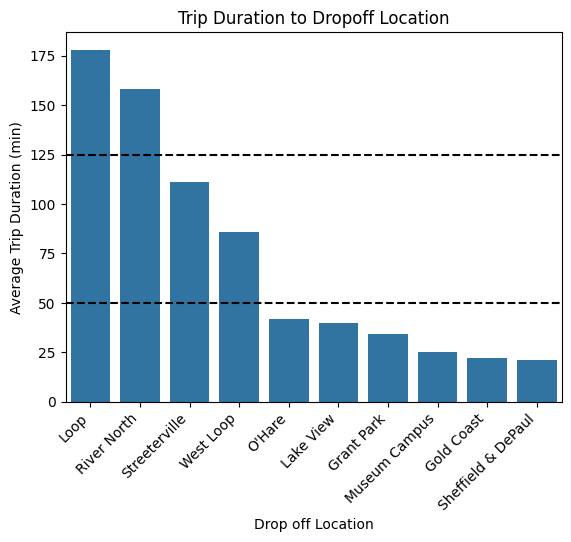

In [67]:
sns.barplot(x='dropoff_location_name', 
            y='average_trips', 
            data=dropoff_top_ten)
plt.axhline(y=50, color='black', linestyle='--')
plt.axhline(y=125, color='black', linestyle='--')
plt.xlabel('Drop off Location')
plt.ylabel('Average Trip Duration (min)')
plt.title('Trip Duration to Dropoff Location')
plt.xticks(rotation=45, ha='right')
plt.show()

As mentioned previously, we can see that there is a sort of stagger at two locations within the data.

### 3.2 High Trip Companies
Now let's delve into identifying the companies with a significant number of trips. Previously, we noted that there are 64 listed companies. To understand the distribution of trips among these companies, we'll first filter out those with more than 5,000 trips. If necessary, we'll adjust our range to focus on the top ten companies.

In [68]:
high_trip_companies = company_trips_amount[company_trips_amount.trips_amount >= 5000]
print(high_trip_companies)

                         company_name  trips_amount
0                           Flash Cab         19558
1           Taxi Affiliation Services         11422
2                    Medallion Leasin         10367
3                          Yellow Cab          9888
4     Taxi Affiliation Service Yellow          9299
5           Chicago Carriage Cab Corp          9181
6                        City Service          8448
7                            Sun Taxi          7701
8           Star North Management LLC          7455
9   Blue Ribbon Taxi Association Inc.          5953
10            Choice Taxi Association          5015


Out of the 64 companies, only 11 exceed 5000 trips. Our initial data inspection revealed that 'Flash Cab' leads with the highest number of trips, and this filter confirms its substantial lead over other companies.

To gain further insights, let's view these values as percentages. We'll sum the 'trips_amount' column, divide each company's trips by this total, and then focus on the top ten companies.

In [69]:
trips_sum = company_trips_amount['trips_amount'].sum()
normalized_trips_df = company_trips_amount[['company_name']].copy()
normalized_trips_df['normalized_trips'] = (company_trips_amount['trips_amount'] / trips_sum)
normalized_trips_df.head(10)

,company_name,normalized_trips
0,Flash Cab,0.142436
1,Taxi Affiliation Services,0.083183
2,Medallion Leasin,0.075500
3,Yellow Cab,0.072012
4,Taxi Affiliation Service Yellow,0.067722
5,Chicago Carriage Cab Corp,0.066863
6,City Service,0.061525
7,Sun Taxi,0.056084
8,Star North Management LLC,0.054293
9,Blue Ribbon Taxi Association Inc.,0.043354


'Flash Cab' holds a significant 14.2% share of the market, leading 'Taxi Affiliation Services' by approximately 5.9%. Compared to the 10th most utilized company, 'Flash Cab' has a notable 9.9% advantage. This indicates a strong dominance in the Chicago taxi/ride-share market. Given that there are 64 companies in the dataset, it suggests a pronounced right skew in the distribution of trips. Rather than an even distribution of rides among companies, a few companies hold a large share of the market. Let's visualize this via an interactive scatter plot. To elaborate, instead of seeing an even distribution of rides between companies, we see a few companies holding a large share of the market. Let's visualize this via an interactive scatter plot.

In [70]:
fig = px.scatter(company_trips_amount, 
                 x=company_trips_amount.index, 
                 y='trips_amount', 
                 hover_name='company_name', 
                 trendline= 'lowess', 
                 trendline_options=dict(frac=0.225))
fig.update_layout(title={'text': 'Number of Trips Per Company', 
                         'x': 0.5},
                  xaxis_title='Company Name', 
                  xaxis_showticklabels=False, 
                  yaxis_title='Amount of Trips')
fig.show()

Why are there four distinct linear segments in the data? Specifically, 'Flash Cab' is an outlier, followed by a sharp decline from index[1:15]. From index[14:26], the slope is less steep, then from index[25:36], the slope is almost flat, with the remaining data showing nearly zero slope. I've added a lowess trendline to aid in seeing the trend.

Let's look at the distribution.

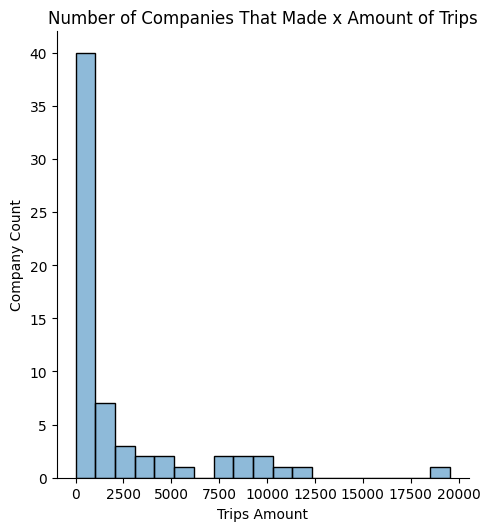

In [71]:
sns.displot(data=company_trips_amount, legend=False)
plt.xlabel('Trips Amount')
plt.ylabel('Company Count')
plt.title('Number of Companies That Made x Amount of Trips', loc='center')
plt.show()

In [72]:
low_trip_companies = company_trips_amount[company_trips_amount.trips_amount < 1000]
print(low_trip_companies.count())

company_name    39
trips_amount    39
dtype: int64


This graph along with the previous one shows that there certainly is not an even distribution of trips between companies. A significant amount of these companies recieve few rides. In addition to that, the code cell above shows that out of the 64 companies, 39 have less than 1000 trips, which is ~61% of the companies.

### 3.3 EDA Conclusion 
To summarize our gatherings:  
- Rides to the Loop and River North have the longest duration; the former takes approximately 178 minutes, while the latter takes roughly 158 minutes.
- 'Flash Cab' dominates the taxi/ride-share market with 19,558 trips, which is 14.2% of all trips in the dataset. 
- Of the 64 companies in the dataset, only 11 have  >5,000 trips, while 39 have <1,000 trips. 

# 4.0 Hypothesis
Does the average duration of rides from the Loop to O'Hare International Airport change on rainy Saturdays?

**Null Hypothesis (H0):**  
Rainy Saturdays do not affect trip duration from the Loop to O'Hare International Airport.

**Alternative Hypothesis (H1):**  
Weather conditions and the day of the week do affect trip duration from the Loop to O'Hare International Airport.

**Formulation of Hypotheses:**  
The null hypothesis posits that there is no significant difference between a subset of data and the overall dataset. Conversely, the alternative hypothesis suggests the opposite. In this context, we are considering two variables: weather and day of the week. Our null hypothesis asserts that trip duration remains unaffected by these variables, while our alternative hypothesis contends that both weather conditions and the day of the week significantly influence trip duration.

**Days in November 2017 that were Saturdays:**  
The 4th, 11th, 18th, and 25th of November 2017 were Saturdays.

### 4.1 Hypothesis Approach
We need pickup_weather_ride_duration['weather_conditions'] and dropoff_trips_avg['dropoff_location_name'] to test this hypothesis, so we'll create an empty column in both dataframes named 'temporary_column' in order to have something in common for the dataframes to merge on; after the merge, we'll drop the redundant column.


In [73]:
# Creating a new column to merge the dataframes
pickup_weather_ride_duration['temporary_column'] = None
dropoff_trips_avg['temporary_column'] = None

In [74]:
# Merging the dataframes
df_joined = pickup_weather_ride_duration.join(dropoff_trips_avg.set_index('temporary_column'), 
                                              on='temporary_column')
df_joined.head()

,start_ts,weather_conditions,duration_seconds,temporary_column,dropoff_location_name,average_trips
0,2017-11-25 16:00:00,Good,2410,None,Loop,10727
0,2017-11-25 16:00:00,Good,2410,None,River North,9524
0,2017-11-25 16:00:00,Good,2410,None,Streeterville,6665
0,2017-11-25 16:00:00,Good,2410,None,West Loop,5164
0,2017-11-25 16:00:00,Good,2410,None,O'Hare,2547


In [75]:
# Dropping the temporary column
df_joined = df_joined.drop(columns=['temporary_column'])
df_joined.head()

,start_ts,weather_conditions,duration_seconds,dropoff_location_name,average_trips
0,2017-11-25 16:00:00,Good,2410,Loop,10727
0,2017-11-25 16:00:00,Good,2410,River North,9524
0,2017-11-25 16:00:00,Good,2410,Streeterville,6665
0,2017-11-25 16:00:00,Good,2410,West Loop,5164
0,2017-11-25 16:00:00,Good,2410,O'Hare,2547


Let's use the .describe() method to view the stats and then create a boxplot as a visual.

In [76]:
df_joined['duration_seconds'].describe()

count    81874.000000
mean      2096.308840
std        781.830296
min          0.000000
25%       1440.000000
50%       2015.000000
75%       2588.000000
max       7440.000000
Name: duration_seconds, dtype: float64

Text(0.5, 1.0, 'Ride Duration Quartiles and Outliers')

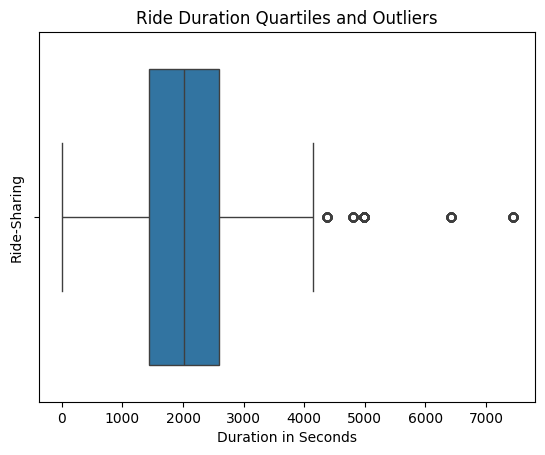

In [77]:
ax = sns.boxplot(data= df_joined, 
                 x= 'duration_seconds') 

ax.set_xlabel('Duration in Seconds')
ax.set_ylabel('Ride-Sharing')
ax.set_title('Ride Duration Quartiles and Outliers')

From the description and boxplot above, we see the following: 
- The mean is ~2096 seconds. 
- There are five outliers - the largest being nearly double the highest value in the top percentile.

Now we'll convert the start_ts column to datetime using the pandas method to_datetime so that we can filter the dataframe for Saturdays. Then we'll split the dataframe into two based on whether the weather is good or bad, ensure that only information for Saturdays is present, and that the drop off location is O'Hare International Airport. Afterwards, we'll print the first five rows of both dataframes along with the shape for a quick overview of the data.

In [78]:
df_joined.start_ts = pd.to_datetime(df_joined.start_ts)

df_good_saturdays = df_joined[(df_joined['weather_conditions'] == 'Good') & 
                              (df_joined['start_ts'].dt.dayofweek == 5) & 
                              (df_joined['dropoff_location_name'] == "O'Hare")].drop(columns=['average_trips'])

df_bad_saturdays = df_joined[(df_joined['weather_conditions'] == 'Bad') & 
                             (df_joined['start_ts'].dt.dayofweek == 5) & 
                             (df_joined['dropoff_location_name'] == "O'Hare")].drop(columns=['average_trips'])

In [79]:
print('Good Saturdays:')
display(df_good_saturdays.head(), df_good_saturdays.shape)
print('Bad Saturdays:')
display(df_bad_saturdays.head(), df_bad_saturdays.shape)

Good Saturdays:


,start_ts,weather_conditions,duration_seconds,dropoff_location_name
0,2017-11-25 16:00:00,Good,2410,O'Hare
1,2017-11-25 14:00:00,Good,1920,O'Hare
2,2017-11-25 12:00:00,Good,1543,O'Hare
3,2017-11-04 10:00:00,Good,2512,O'Hare
4,2017-11-11 07:00:00,Good,1440,O'Hare


(723, 4)

Bad Saturdays:


,start_ts,weather_conditions,duration_seconds,dropoff_location_name
6,2017-11-04 16:00:00,Bad,2969,O'Hare
30,2017-11-18 12:00:00,Bad,1980,O'Hare
34,2017-11-04 17:00:00,Bad,2460,O'Hare
51,2017-11-04 16:00:00,Bad,2760,O'Hare
52,2017-11-18 12:00:00,Bad,2460,O'Hare


(148, 4)

Next let's calculate the average trip duration depending on weather condition. To do so, we'll take the sum of the duration_seconds column in both tables, then divide by the number of rows in the respective dataset and convert the result to an integer. I've chosen to do this because the column represents seconds; having a float value is far too specific.

In [80]:
good_duration_sum = df_good_saturdays['duration_seconds'].sum()
bad_duration_sum = df_bad_saturdays['duration_seconds'].sum()

good_trip_avg = int(good_duration_sum / df_good_saturdays['duration_seconds'].count())
bad_trip_avg = int(bad_duration_sum / df_bad_saturdays['duration_seconds'].count())

display(f'Trip average during good weather: {good_trip_avg} seconds', 
        f'Trip average during bad weather: {bad_trip_avg} seconds')

'Trip average during good weather: 2032 seconds'

'Trip average during bad weather: 2409 seconds'

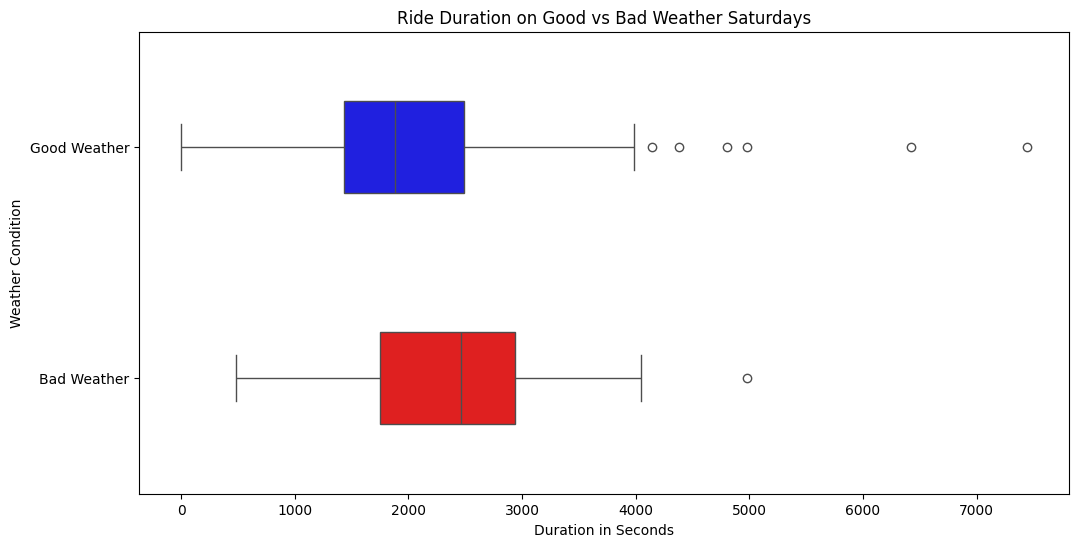

In [97]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.boxplot(data= df_good_saturdays, 
            x= 'duration_seconds', 
            y= ['Good Weather']*len(df_good_saturdays), 
            ax= ax, 
            color= 'blue', 
            width= 0.4)

sns.boxplot(data= df_bad_saturdays, 
            x='duration_seconds', 
            y= ['Bad Weather']*len(df_bad_saturdays), 
            ax= ax, 
            color= 'red', 
            width= 0.4)

ax.set_title('Ride Duration on Good vs Bad Weather Saturdays')
ax.set_xlabel('Duration in Seconds')
ax.set_ylabel('Weather Condition')

plt.show()

Here we see the following: 
- The shortest trips on bad weather days last longer than those on good weather days. 
- The interquartile range for bad weather days is tends to being higher than good weather days. 
- The mean duration for bad weather days is roughly the same as the top of the interquartile range of good weather days. 
- Good weather days has 6 outliers; we noticed the largest two earlier in our df_joined boxplot. Conversely, bad weather days has only one outlier.

In [81]:
good_trip_avg_min = round(good_trip_avg / 60)
bad_trip_avg_min = round(bad_trip_avg / 60)

display(f'Trip average during good weather: {good_trip_avg_min} minutes', 
        f'Trip average during bad weather: {bad_trip_avg_min} minutes')

'Trip average during good weather: 34 minutes'

'Trip average during bad weather: 40 minutes'

Our results above indicate that there is a difference in ride duration from the Loop to O'Hare International Airport depending on weather condition. When the weather is good, a trip on average lasts 34 minutes, whereas during bad weather, the duration is approximately 40 minutes. Upon testing the p-value, a conclusion will be made.

### 4.2 P-value test
Let's now test the p-value. Because the information were working with doesn't need to be so stringent as to use a value of say, 0.01, we'll use the commonplace threshold of 0.05, represented by the variable 'alpha'. Remember we are testing whether or no ride duration is affected by weather, so we'll use the 'duration_seconds' column from both dataframes representing good and bad weather. 

If the p-value is >0.05, then we accept the null hypothesis. As a reminder, our null hypothesis is as follows:  
- Rainy Saturdays do not affect trip duration from the Loop to O'Hare International Airport.

If the p-value is <0.05 then we reject the null hypothesis. As a reminder, our alternative hypothesis is as follows:  
- Weather conditions and the day of the week do affect trip duration from the Loop to O'Hare International Airport.

In [82]:
alpha = 0.05

t_stat, p_value = stats.ttest_ind (df_good_saturdays['duration_seconds'], 
                                   df_bad_saturdays['duration_seconds'], 
                                   equal_var= True)

print(f'p-value: {p_value}')

if p_value > 0.05: 
    print('We accept the null hypothesis')
else: 
    print('We reject the null hypothesis')

p-value: 7.397770692813658e-08
We reject the null hypothesis


Our p-value is far below our the p-value hypothesis, therefore we reject the null hypothesis. Our results suggest that there is indeed a difference in ride duration based on weather conditions. 

# 5.0 Conclusion

In this section, we will recap the key findings of this project and provide a comprehensive summary of our results.

**Top Ten Neighborhoods for Drop-offs**  
The top ten neighborhoods for drop-offs, listed in descending order, are:
- The Loop
- River North
- Streeterville
- West Loop
- O'Hare International Airport
- Lake View
- Grant Park
- Museum Campus
- Gold Coast
- Sheffield & DePaul

**Observations on Top Ten Neighborhoods**
- Trips to the Loop and River North have the longest durations, averaging 178 minutes and 158 minutes, respectively.
- There are two significant drops in trip duration: the first between River North and Streeterville, where the latter averages 111 minutes, a 42% decrease from River North's 158 minutes. The second drop occurs between West Loop and O'Hare, with the former averaging 86 minutes and the latter 42 minutes, less than half the time of the former.

**Top Ten Taxi/Ride-Sharing Companies**  
The top ten companies, in descending order, are:
- Flash Cab
- Taxi Affiliation Services
- Medallion Leasin
- Yellow Cab
- Taxi Affiliation Services Yellow
- Chicago Carriage Cab Corp
- City Service
- Sun Taxi
- Star North Management LLC
- Blue Ribbon Taxi Association Inc.

**Observations on High Trip Companies**
- Flash Cab dominates the market with 19,558 trips, accounting for 14.2% of all trips. The second most used service, Taxi Affiliation Services, has 11,422 trips, representing 8.3% of all trips.
- Out of the 64 companies listed, only 11 have provided over 5,000 rides, while 39 have fewer than 1,000 rides, which is approximately 61% of the companies. This indicates a concentration of business among a few companies rather than an even distribution.

**Impact of Weather on Trip Duration**
- Trips from the Loop to O'Hare average 34 minutes during good weather and approximately 40 minutes during bad weather. Using a significance threshold of 0.05, we obtained a p-value of 7.397770692813658e-08, leading us to reject the null hypothesis. This suggests that weather conditions do indeed affect trip duration.

**Possible Reasons for Longer Trip Durations During Bad Weather**
- Drivers may exercise more caution.
- The likelihood of accidents increases, potentially causing delays.
- Flooding or other hazardous conditions may necessitate detours, slowing travel time.

In conclusion, our analysis reveals significant insights into trip durations and the distribution of trips among neighborhoods and companies. Additionally, we have established that weather conditions have a measurable impact on trip durations from the Loop to O'Hare International Airport.